## Hyperspectral Image Segmentation by Convolutional Neural Network 

### standardized spectra at full resolution with spatial dimension included

---

#### Testing changing CNN filter sizes on the accuracy and mF1 of veg_00108

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## CNN on veg_00108 (South Facing @ ~2pm)

In [8]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [9]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [10]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [11]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)

In [12]:
# create position array and normalize

xycoords = coords(cube_sub.shape[1], cube_sub.shape[2])
xycoords = xycoords/xycoords.max()

In [13]:
# append row, col position matrix to spectral data

cube_temp = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_specxy = np.append(cube_temp, xycoords, axis=2)

In [14]:
# reshape spectral and spatial cube for clustering
cube_specxy_2d = cube_specxy.reshape((cube_specxy.shape[0] * cube_specxy.shape[1]), cube_specxy.shape[2])
print(cube_specxy_2d.shape)

(2560000, 850)


#### Reading manually classified set for training and testing

In [15]:
# read manually selected coordinates files

#sky coordinates
sky_file = open("../manual_classified_pixels/1_sky_coordinates_108.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print("sky:        ", sky_coords.shape)

#clouds coordinates
clouds_file = open("../manual_classified_pixels/2_clouds_coordinates_108.txt", "r")
clouds_coords = clouds_file.readlines()
clouds_file.close()
clouds_coords = np.array([point_from_string(line) for line in clouds_coords])
print("clouds:     ", clouds_coords.shape)

#vegetation coordinates
veg_file = open("../manual_classified_pixels/3_vegetation_coordinates_108.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print("vegetation: ", veg_coords.shape)

#water coordinates
wtr_file = open("../manual_classified_pixels/4_water_coordinates_108.txt", "r")
wtr_coords = wtr_file.readlines()
wtr_file.close()
wtr_coords = np.array([point_from_string(line) for line in wtr_coords])
print("water:      ", wtr_coords.shape)

#buildings coordinates
blt_file = open("../manual_classified_pixels/5_buildings_coordinates_108.txt", "r")
blt_coords = blt_file.readlines()
blt_file.close()
blt_coords = np.array([point_from_string(line) for line in blt_coords])
print("buildings:  ", blt_coords.shape)

#windows coordinates
windows_file = open("../manual_classified_pixels/6_windows_coordinates_108.txt", "r")
windows_coords = windows_file.readlines()
windows_file.close()
windows_coords = np.array([point_from_string(line) for line in windows_coords])
print("windows:    ", windows_coords.shape)

#roads coordinates
rds_file = open("../manual_classified_pixels/7_roads_coordinates_108.txt", "r")
rds_coords = rds_file.readlines()
rds_file.close()
rds_coords = np.array([point_from_string(line) for line in rds_coords])
print("road:       ", rds_coords.shape)

#cars coordinates
cars_file = open("../manual_classified_pixels/8_cars_coordinates_108.txt", "r")
cars_coords = cars_file.readlines()
cars_file.close()
cars_coords = np.array([point_from_string(line) for line in cars_coords])
print("cars:       ", cars_coords.shape)

#metal coordinates
mtl_file = open("../manual_classified_pixels/9_metal_coordinates_108.txt", "r")
mtl_coords = mtl_file.readlines()
mtl_file.close()
mtl_coords = np.array([point_from_string(line) for line in mtl_coords])
print("metal:      ", mtl_coords.shape)

sky:         (300, 2)
clouds:      (500, 2)
vegetation:  (600, 2)
water:       (50, 2)
buildings:   (1020, 2)
windows:     (500, 2)
road:        (30, 2)
cars:        (100, 2)
metal:       (100, 2)


#### split classified pixels into 80% training and 20% testing sets

In [16]:
import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.Random(3).shuffle(sky_ind)
lim_ind = int(len(sky_ind)*0.8)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# clouds coordinates
clouds_ind = np.arange(clouds_coords.shape[0])
random.Random(3).shuffle(clouds_ind)
lim_ind = int(len(clouds_ind)*0.8)
clouds_train_ind = clouds_ind[:lim_ind]
clouds_test_ind = clouds_ind[lim_ind:]
print("clouds %d %d" % (len(clouds_train_ind), len(clouds_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.Random(3).shuffle(veg_ind)
lim_ind = int(len(veg_ind)*0.8)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("vegetation %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# water coordinates
wtr_ind = np.arange(wtr_coords.shape[0])
random.Random(3).shuffle(wtr_ind)
lim_ind = int(len(wtr_ind)*0.8)
wtr_train_ind = wtr_ind[:lim_ind]
wtr_test_ind = wtr_ind[lim_ind:]
print("water %d %d" % (len(wtr_train_ind), len(wtr_test_ind)))

# built coordinates
blt_ind = np.arange(blt_coords.shape[0])
random.Random(3).shuffle(blt_ind)
lim_ind = int(len(blt_ind)*0.8)
blt_train_ind = blt_ind[:lim_ind]
blt_test_ind = blt_ind[lim_ind:]
print("built %d %d" % (len(blt_train_ind), len(blt_test_ind)))

# windows coordinates
windows_ind = np.arange(windows_coords.shape[0])
random.Random(3).shuffle(windows_ind)
lim_ind = int(len(windows_ind)*0.8)
windows_train_ind = windows_ind[:lim_ind]
windows_test_ind = windows_ind[lim_ind:]
print("windows %d %d" % (len(windows_train_ind), len(windows_test_ind)))

# roads coordinates
rds_ind = np.arange(rds_coords.shape[0])
random.Random(3).shuffle(rds_ind)
lim_ind = int(len(rds_ind)*0.8)
rds_train_ind = rds_ind[:lim_ind]
rds_test_ind = rds_ind[lim_ind:]
print("roads %d %d" % (len(rds_train_ind), len(rds_test_ind)))

# cars coordinates
cars_ind = np.arange(cars_coords.shape[0])
random.Random(3).shuffle(cars_ind)
lim_ind = int(len(cars_ind)*0.8)
cars_train_ind = cars_ind[:lim_ind]
cars_test_ind = cars_ind[lim_ind:]
print("cars %d %d" % (len(cars_train_ind), len(cars_test_ind)))

# metal coordinates
mtl_ind = np.arange(mtl_coords.shape[0])
random.Random(3).shuffle(mtl_ind)
lim_ind = int(len(mtl_ind)*0.8)
mtl_train_ind = mtl_ind[:lim_ind]
mtl_test_ind = mtl_ind[lim_ind:]
print("metal %d %d" % (len(mtl_train_ind), len(mtl_test_ind)))

sky 240 60
clouds 400 100
vegetation 480 120
water 40 10
built 816 204
windows 400 100
roads 24 6
cars 80 20
metal 80 20


In [17]:
cube_sky_train = cube_specxy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_specxy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_specxy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_specxy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_specxy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_specxy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_specxy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_specxy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_specxy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_specxy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_specxy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
cube_windows_test = cube_specxy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_specxy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_specxy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_specxy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_specxy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_specxy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_specxy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (240, 850) (60, 850)
clouds  (400, 850) (100, 850)
vegetation  (480, 850) (120, 850)
water  (40, 850) (10, 850)
built  (816, 850) (204, 850)
windows  (400, 850) (100, 850)
roads  (24, 850) (6, 850)
cars  (80, 850) (20, 850)
metal  (80, 850) (20, 850)


In [18]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]

print(cube_train.shape)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]

print(cube_test.shape)

(2560, 850)
(640, 850)


In [19]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

___
## Train CNN
### Filter size = 2
#### number fo filters = 16, 32

In [20]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(2), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(2), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Epoch 1/100
5/5 [==============================] - 1s 139ms/step - loss: 1.7122 - accuracy: 0.4020 - val_loss: 1.1359 - val_accuracy: 0.7453
Epoch 2/100
5/5 [==============================] - 0s 88ms/step - loss: 1.0048 - accuracy: 0.7027 - val_loss: 0.8480 - val_accuracy: 0.7109
Epoch 3/100
5/5 [==============================] - 0s 88ms/step - loss: 0.7801 - accuracy: 0.7781 - val_loss: 0.7023 - val_accuracy: 0.7281
Epoch 4/100
5/5 [==============================] - 0s 88ms/step - loss: 0.6712 - accuracy: 0.7980 - val_loss: 0.6211 - val_accuracy: 0.8297
Epoch 5/100
5/5 [==============================] - 0s 95ms/step - loss: 0.5791 - accuracy: 0.8449 - val_loss: 0.5511 - val_accuracy: 0.8672
Epoch 6/100
5/5 [==============================] - 0s 87ms/step - loss: 0.5309 - accuracy: 0.8535 - val_loss: 0.4993 - val_accuracy: 0.8656
Epoch 7/100
5/5 [==============================] - 0s 89ms/step - loss: 0.4763 - accuracy: 0.8660 - val_loss: 0.4626 - val_accuracy: 0.8656
Epoch 8/100
5/5 [==

5/5 [==============================] - 0s 86ms/step - loss: 0.1541 - accuracy: 0.9484 - val_loss: 0.2092 - val_accuracy: 0.9203
Epoch 60/100
5/5 [==============================] - 0s 89ms/step - loss: 0.1551 - accuracy: 0.9484 - val_loss: 0.2100 - val_accuracy: 0.9219
Epoch 61/100
5/5 [==============================] - 1s 107ms/step - loss: 0.1498 - accuracy: 0.9508 - val_loss: 0.1954 - val_accuracy: 0.9219
Epoch 62/100
5/5 [==============================] - 1s 100ms/step - loss: 0.1410 - accuracy: 0.9465 - val_loss: 0.1992 - val_accuracy: 0.9250
Epoch 63/100
5/5 [==============================] - 0s 98ms/step - loss: 0.1363 - accuracy: 0.9570 - val_loss: 0.1990 - val_accuracy: 0.9219
Epoch 64/100
5/5 [==============================] - 1s 110ms/step - loss: 0.1342 - accuracy: 0.9512 - val_loss: 0.2038 - val_accuracy: 0.9141
Epoch 65/100
5/5 [==============================] - 1s 102ms/step - loss: 0.1374 - accuracy: 0.9531 - val_loss: 0.1948 - val_accuracy: 0.9203
Epoch 66/100
5/5 [====

<function matplotlib.pyplot.show(*args, **kw)>

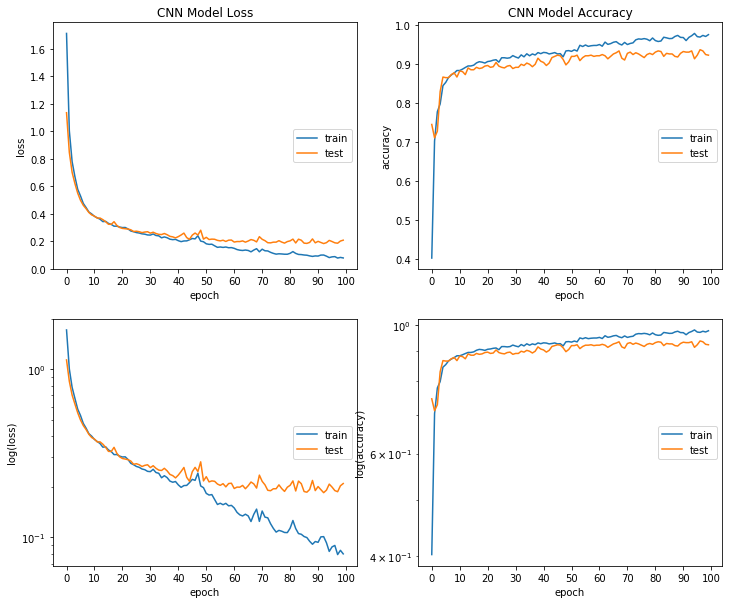

In [21]:
# summarize history of loss
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_change_params_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [22]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(2), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(2), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

!rm -rf ./logs/
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=25, batch_size=512, callbacks=[tensorboard_callback])

Epoch 1/25
1/5 [=====>........................] - ETA: 0s - loss: 2.2605 - accuracy: 0.1250

W0425 15:22:39.935780 140652027393536 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


5/5 [==============================] - 1s 161ms/step - loss: 2.0553 - accuracy: 0.3504 - val_loss: 1.3469 - val_accuracy: 0.4938
Epoch 2/25
5/5 [==============================] - 1s 102ms/step - loss: 1.1967 - accuracy: 0.6098 - val_loss: 1.0168 - val_accuracy: 0.6328
Epoch 3/25
5/5 [==============================] - 0s 84ms/step - loss: 0.9684 - accuracy: 0.6812 - val_loss: 0.8540 - val_accuracy: 0.7234
Epoch 4/25
5/5 [==============================] - 0s 84ms/step - loss: 0.8320 - accuracy: 0.7500 - val_loss: 0.7656 - val_accuracy: 0.7984
Epoch 5/25
5/5 [==============================] - 0s 86ms/step - loss: 0.7396 - accuracy: 0.7738 - val_loss: 0.7058 - val_accuracy: 0.8031
Epoch 6/25
5/5 [==============================] - 0s 85ms/step - loss: 0.6836 - accuracy: 0.8148 - val_loss: 0.6447 - val_accuracy: 0.8078
Epoch 7/25
5/5 [==============================] - 0s 82ms/step - loss: 0.6288 - accuracy: 0.8270 - val_loss: 0.5955 - val_accuracy: 0.8172
Epoch 8/25
5/5 [====================

In [23]:
# model accuracy on training and testing sets

train_loss_2, train_acc_2 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_2, test_acc_2 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_2, test_acc_2)

20/20 [==============================] - 0s 7ms/step - loss: 0.3063 - accuracy: 0.8938
0.9058593511581421 0.893750011920929


In [24]:
print(cube_train_labels.shape)
print(cube_test_labels.shape)

(2560,)
(640,)


In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir logs

In [25]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
#plot_model(cnn, to_file='./plots/model_CNN_change_params.png', show_shapes=True,
#                      show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300)

In [26]:
from keras_sequential_ascii import keras2ascii
keras2ascii(cnn)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    850    1
              Conv1D    \|/  -------------------        48     0.0%
                relu   #####    850   16
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    425   16
              Conv1D    \|/  -------------------      1056     0.0%
                relu   #####    425   32
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    212   32
             Dropout    | || -------------------         0     0.0%
                       #####    212   32
             Flatten   ||||| -------------------         0     0.0%
                       #####        6784
               Dense   XXXXX -------------------   3473920    99.8%
                relu   #####         512
               Dense   XXXXX -------------------      4617     0.1%
             softmax   #####           9


In [27]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 850, 16)           48        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 425, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 425, 32)           1056      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 212, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 212, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6784)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

### Predict pixel classification on veg_00108 (filter size = 2)

In [28]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

W0425 15:23:56.798384 140652027393536 deprecation.py:323] From <ipython-input-28-49aec12567a0>:6: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


00:08:59


In [30]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

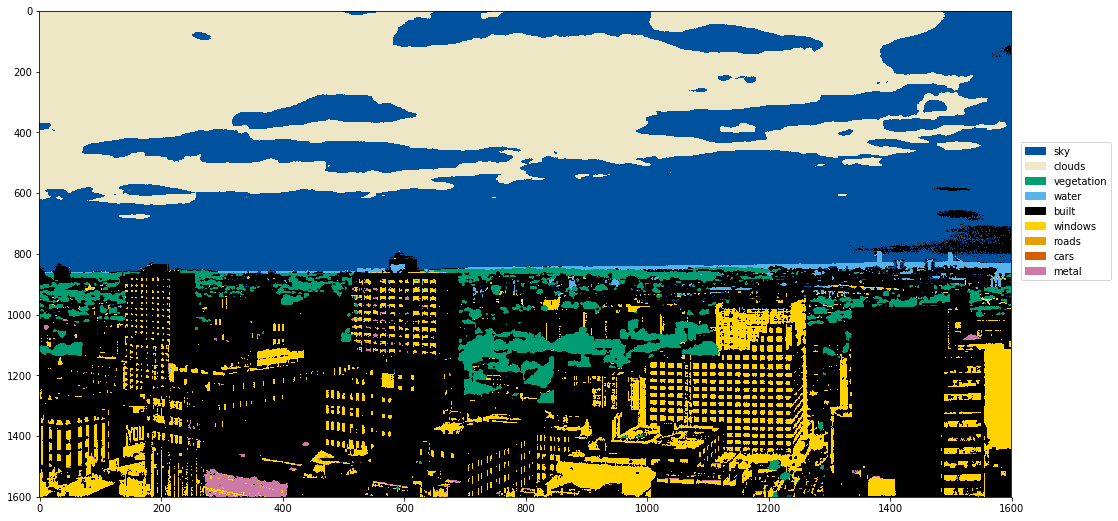

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

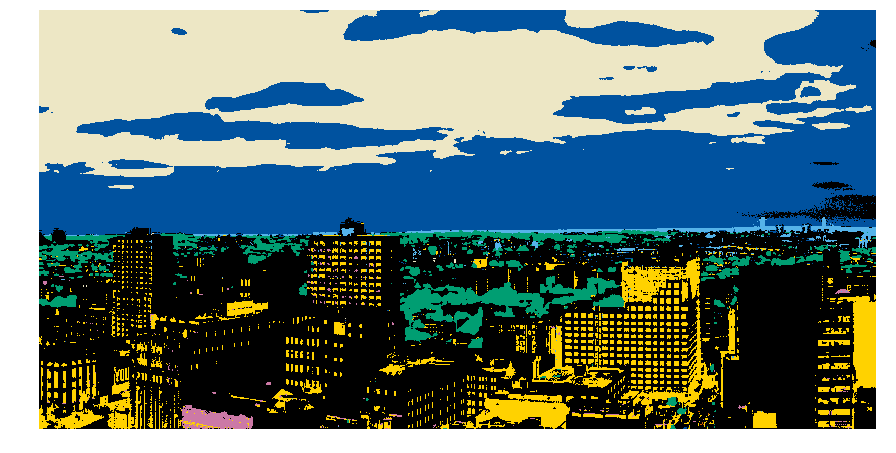

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_spatial_train_108_filter_size_2_predict_map.png", bbox_inches='tight', dpi=300)

In [33]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/CNN_spatial_train_108_filter_size_2_predict_map.pickle", "wb"))

In [ ]:
#import pickle
#file = open("./plots/CNN_change_params_spatial_train_108_6_108_predict_map.pickle", "rb")
#predictCube_reshape = pickle.load(file)

In [ ]:
#predictCube = predictCube_reshape.reshape(cube_specxy.shape[0]*cube_specxy.shape[1])

### Evaluation Metrics (veg_00108) (filter size = 2)

In [34]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [35]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [36]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [37]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 118   0   2   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 201   3   0   0   0]
 [  0   0   0   0  18  81   0   0   1]
 [  0   0   0   0   6   0   0   0   0]
 [  0   0   0   0  18   1   0   0   1]
 [  0   0   0   0  15   3   0   0   2]]

Accuracy Score
0.89375

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      0.98      0.99       120
      water       1.00      1.00      1.00        10
      built       0.77      0.99      0.87       204
    windows       0.92      0.81      0.86       100
      roads       0.00      0.00      0.00         6
       cars       0.00      0.00      0.00        20
      metal       0.50      0.10      0.17        20

avg / total       0.86      0.89      0.87       640

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
f = open("./metrics/CNN_spatial_train_108_filter_size_2_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3    4    5  6  7  8
sky         300    0    0   0    0    0  0  0  0
clouds        1  499    0   0    0    0  0  0  0
vegetation    0    0  593   1    6    0  0  0  0
water         0    0    0  50    0    0  0  0  0
built         4    0    0   6  999   11  0  0  0
windows       0    0    0   0   57  442  0  0  1
roads         0    0    0   0   30    0  0  0  0
cars          6    0    0   0   81    9  0  0  4
metal         0    0    0   0   82   10  0  0  8


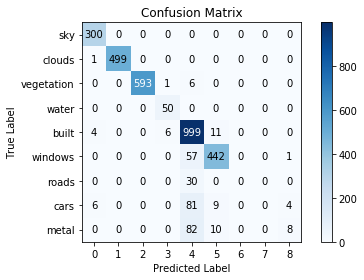

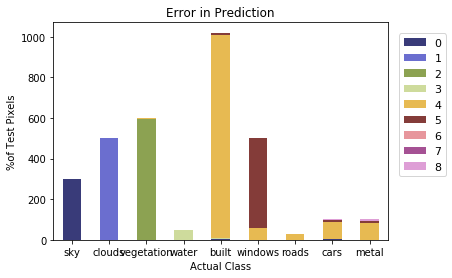

In [40]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

___
## Train CNN
### Filter size = 5
#### number fo filters = 16, 32

In [41]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(5), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(5), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Epoch 1/100
5/5 [==============================] - 1s 179ms/step - loss: 1.6600 - accuracy: 0.4313 - val_loss: 1.1128 - val_accuracy: 0.7547
Epoch 2/100
5/5 [==============================] - 0s 92ms/step - loss: 0.9826 - accuracy: 0.6949 - val_loss: 0.8189 - val_accuracy: 0.7312
Epoch 3/100
5/5 [==============================] - 0s 86ms/step - loss: 0.7340 - accuracy: 0.8020 - val_loss: 0.6625 - val_accuracy: 0.7984
Epoch 4/100
5/5 [==============================] - 0s 87ms/step - loss: 0.6230 - accuracy: 0.8238 - val_loss: 0.5624 - val_accuracy: 0.8281
Epoch 5/100
5/5 [==============================] - 1s 105ms/step - loss: 0.5392 - accuracy: 0.8523 - val_loss: 0.4985 - val_accuracy: 0.8656
Epoch 6/100
5/5 [==============================] - 1s 114ms/step - loss: 0.4856 - accuracy: 0.8652 - val_loss: 0.4686 - val_accuracy: 0.8766
Epoch 7/100
5/5 [==============================] - 1s 114ms/step - loss: 0.4495 - accuracy: 0.8719 - val_loss: 0.4440 - val_accuracy: 0.8750
Epoch 8/100
5/5 

Epoch 59/100
5/5 [==============================] - 0s 91ms/step - loss: 0.1193 - accuracy: 0.9574 - val_loss: 0.1969 - val_accuracy: 0.9234
Epoch 60/100
5/5 [==============================] - 1s 111ms/step - loss: 0.1342 - accuracy: 0.9559 - val_loss: 0.1727 - val_accuracy: 0.9328
Epoch 61/100
5/5 [==============================] - 1s 107ms/step - loss: 0.1266 - accuracy: 0.9563 - val_loss: 0.1838 - val_accuracy: 0.9422
Epoch 62/100
5/5 [==============================] - 0s 87ms/step - loss: 0.1282 - accuracy: 0.9574 - val_loss: 0.1791 - val_accuracy: 0.9266
Epoch 63/100
5/5 [==============================] - 1s 114ms/step - loss: 0.1214 - accuracy: 0.9594 - val_loss: 0.1832 - val_accuracy: 0.9297
Epoch 64/100
5/5 [==============================] - 1s 108ms/step - loss: 0.1267 - accuracy: 0.9586 - val_loss: 0.1801 - val_accuracy: 0.9266
Epoch 65/100
5/5 [==============================] - 1s 103ms/step - loss: 0.1187 - accuracy: 0.9586 - val_loss: 0.1646 - val_accuracy: 0.9406
Epoch 66

<function matplotlib.pyplot.show(*args, **kw)>

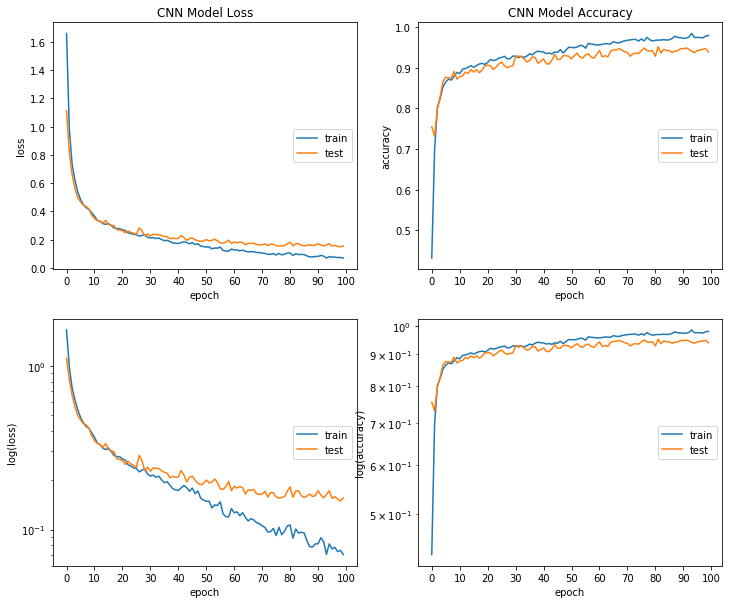

In [42]:
# summarize history of loss
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_change_params_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [43]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(5), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(5), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

!rm -rf ./logs/
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=30, batch_size=512, callbacks=[tensorboard_callback])

Epoch 1/30
2/5 [===========>..................] - ETA: 0s - loss: 2.4991 - accuracy: 0.1973

W0425 15:35:31.060241 140652027393536 callbacks.py:316] Callbacks method `on_train_batch_end` is slow compared to the batch time. Check your callbacks.


5/5 [==============================] - 1s 179ms/step - loss: 2.1188 - accuracy: 0.3082 - val_loss: 1.4889 - val_accuracy: 0.4047
Epoch 2/30
5/5 [==============================] - 0s 87ms/step - loss: 1.3160 - accuracy: 0.5141 - val_loss: 1.1330 - val_accuracy: 0.5953
Epoch 3/30
5/5 [==============================] - 0s 86ms/step - loss: 1.0284 - accuracy: 0.7105 - val_loss: 0.8950 - val_accuracy: 0.7750
Epoch 4/30
5/5 [==============================] - 0s 87ms/step - loss: 0.8388 - accuracy: 0.7707 - val_loss: 0.7742 - val_accuracy: 0.7656
Epoch 5/30
5/5 [==============================] - 0s 93ms/step - loss: 0.7153 - accuracy: 0.7805 - val_loss: 0.6581 - val_accuracy: 0.8281
Epoch 6/30
5/5 [==============================] - 0s 90ms/step - loss: 0.6154 - accuracy: 0.8426 - val_loss: 0.5747 - val_accuracy: 0.8578
Epoch 7/30
5/5 [==============================] - 0s 88ms/step - loss: 0.5482 - accuracy: 0.8535 - val_loss: 0.5243 - val_accuracy: 0.8703
Epoch 8/30
5/5 [=====================

In [44]:
# model accuracy on training and testing sets

train_loss_5, train_acc_5 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_5, test_acc_5 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_5, test_acc_5)

20/20 [==============================] - 0s 10ms/step - loss: 0.2752 - accuracy: 0.9141
0.9242187738418579 0.9140625


In [45]:
print(cube_train_labels.shape)
print(cube_test_labels.shape)

(2560,)
(640,)


In [46]:
from keras_sequential_ascii import keras2ascii
keras2ascii(cnn)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    850    1
              Conv1D    \|/  -------------------        96     0.0%
                relu   #####    850   16
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    425   16
              Conv1D    \|/  -------------------      2592     0.1%
                relu   #####    425   32
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    212   32
             Dropout    | || -------------------         0     0.0%
                       #####    212   32
             Flatten   ||||| -------------------         0     0.0%
                       #####        6784
               Dense   XXXXX -------------------   3473920    99.8%
                relu   #####         512
               Dense   XXXXX -------------------      4617     0.1%
             softmax   #####           9


In [47]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 850, 16)           96        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 425, 16)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 425, 32)           2592      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 212, 32)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 212, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6784)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

### Predict pixel classification on veg_00108 (filter size = 5)

In [48]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:08:47


In [49]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

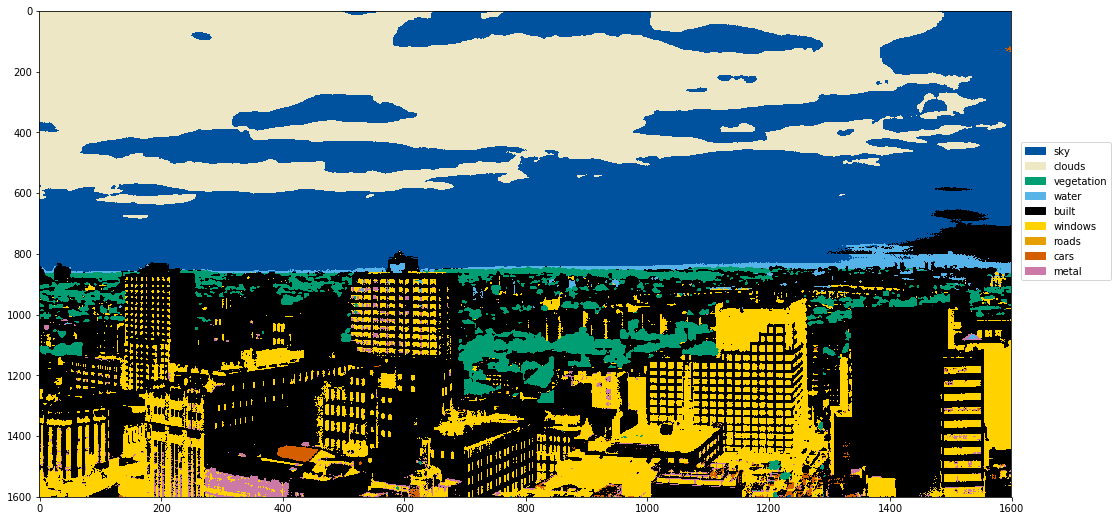

In [50]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

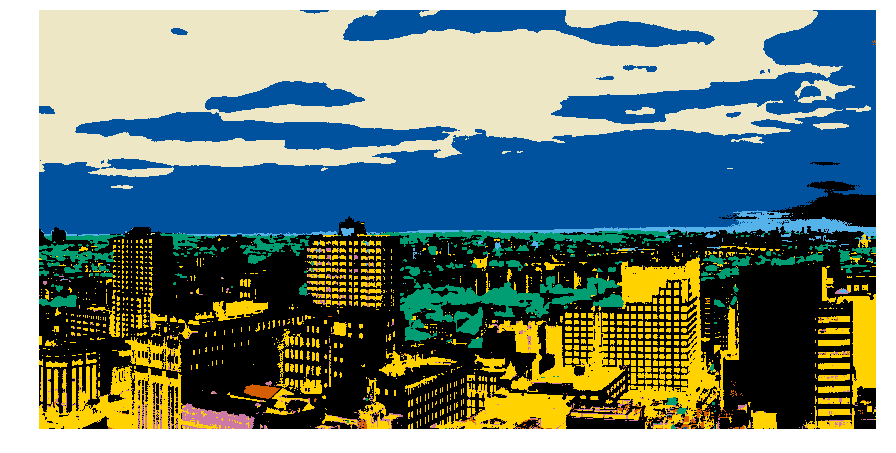

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_spatial_train_108_filter_size_5_predict_map.png", bbox_inches='tight', dpi=300)

In [52]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/CNN_spatial_train_108_filter_size_5_predict_map.pickle", "wb"))

### Evaluation Metrics (veg_00108) (filter size = 5)

In [53]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [54]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [55]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [56]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 118   0   2   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 193  11   0   0   0]
 [  0   0   0   0   6  91   0   1   2]
 [  0   0   0   0   1   5   0   0   0]
 [  0   0   0   0   6   1   0  10   3]
 [  0   0   0   0  10   6   0   1   3]]

Accuracy Score
0.9140625

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      0.98      0.99       120
      water       1.00      1.00      1.00        10
      built       0.89      0.95      0.91       204
    windows       0.80      0.91      0.85       100
      roads       0.00      0.00      0.00         6
       cars       0.83      0.50      0.62        20
      metal       0.38      0.15      0.21        20

avg / total       0.90      0.91      0.90       6

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
f = open("./metrics/CNN_spatial_train_108_filter_size_5_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3    4    5  6   7   8
sky         300    0    0   0    0    0  0   0   0
clouds        1  499    0   0    0    0  0   0   0
vegetation    0    0  593   1    6    0  0   0   0
water         0    0    0  50    0    0  0   0   0
built         0    0    0   7  974   37  0   1   1
windows       0    0    0   0   19  469  0   4   8
roads         0    0    0   0   10   19  0   1   0
cars          5    0    0   0   28   13  0  45   9
metal         0    0    0   0   45   29  0   5  21


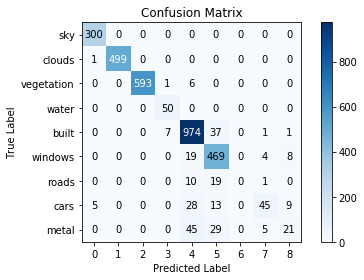

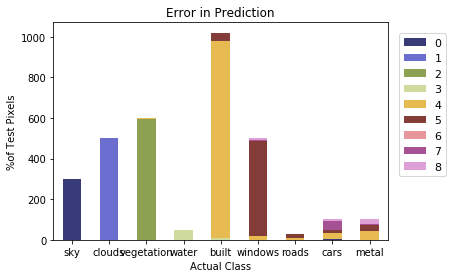

In [59]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

___
## Train CNN
### Filter size = 10
#### number fo filters = 16, 32

In [60]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(10), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(10), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Epoch 1/100
5/5 [==============================] - 1s 160ms/step - loss: 1.7282 - accuracy: 0.3812 - val_loss: 1.2471 - val_accuracy: 0.5891
Epoch 2/100
5/5 [==============================] - 0s 97ms/step - loss: 1.0756 - accuracy: 0.6738 - val_loss: 0.8700 - val_accuracy: 0.7203
Epoch 3/100
5/5 [==============================] - 0s 94ms/step - loss: 0.7927 - accuracy: 0.7648 - val_loss: 0.6825 - val_accuracy: 0.8062
Epoch 4/100
5/5 [==============================] - 1s 102ms/step - loss: 0.6398 - accuracy: 0.8293 - val_loss: 0.5674 - val_accuracy: 0.8703
Epoch 5/100
5/5 [==============================] - 1s 103ms/step - loss: 0.5314 - accuracy: 0.8613 - val_loss: 0.4967 - val_accuracy: 0.8719
Epoch 6/100
5/5 [==============================] - 0s 99ms/step - loss: 0.4792 - accuracy: 0.8672 - val_loss: 0.4754 - val_accuracy: 0.8469
Epoch 7/100
5/5 [==============================] - 1s 121ms/step - loss: 0.4434 - accuracy: 0.8781 - val_loss: 0.4185 - val_accuracy: 0.8891
Epoch 8/100
5/5 

Epoch 59/100
5/5 [==============================] - 1s 111ms/step - loss: 0.1243 - accuracy: 0.9598 - val_loss: 0.1705 - val_accuracy: 0.9422
Epoch 60/100
5/5 [==============================] - 1s 121ms/step - loss: 0.1294 - accuracy: 0.9570 - val_loss: 0.1807 - val_accuracy: 0.9250
Epoch 61/100
5/5 [==============================] - 1s 105ms/step - loss: 0.1210 - accuracy: 0.9602 - val_loss: 0.1979 - val_accuracy: 0.9328
Epoch 62/100
5/5 [==============================] - 0s 98ms/step - loss: 0.1327 - accuracy: 0.9523 - val_loss: 0.1687 - val_accuracy: 0.9344
Epoch 63/100
5/5 [==============================] - 1s 116ms/step - loss: 0.1176 - accuracy: 0.9641 - val_loss: 0.1665 - val_accuracy: 0.9359
Epoch 64/100
5/5 [==============================] - 1s 124ms/step - loss: 0.1169 - accuracy: 0.9609 - val_loss: 0.1714 - val_accuracy: 0.9344
Epoch 65/100
5/5 [==============================] - 0s 96ms/step - loss: 0.1095 - accuracy: 0.9680 - val_loss: 0.1628 - val_accuracy: 0.9312
Epoch 66

<function matplotlib.pyplot.show(*args, **kw)>

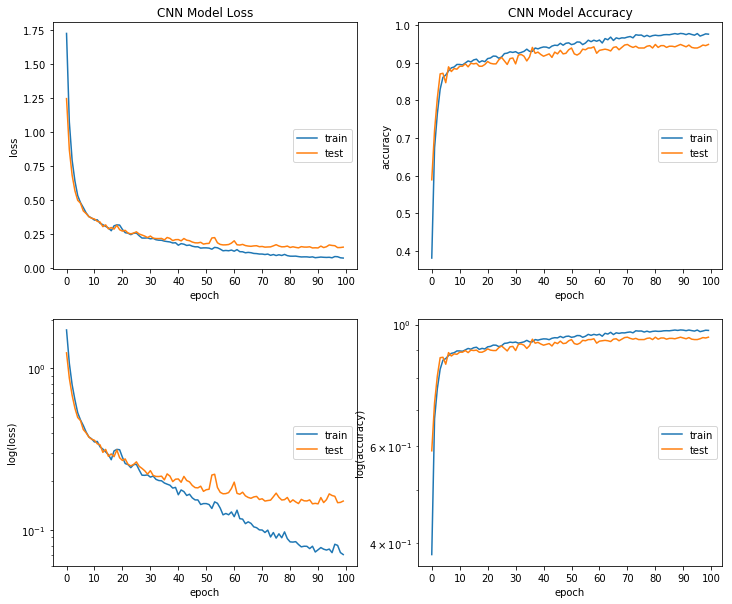

In [61]:
# summarize history of loss
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_change_params_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [62]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(10), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(10), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

!rm -rf ./logs/
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=30, batch_size=512, callbacks=[tensorboard_callback])

Epoch 1/30
2/5 [===========>..................] - ETA: 0s - loss: 2.2504 - accuracy: 0.2842

W0425 15:48:26.392132 140652027393536 callbacks.py:316] Callbacks method `on_train_batch_end` is slow compared to the batch time. Check your callbacks.


5/5 [==============================] - 1s 166ms/step - loss: 1.9733 - accuracy: 0.4070 - val_loss: 1.2573 - val_accuracy: 0.6234
Epoch 2/30
5/5 [==============================] - 0s 92ms/step - loss: 1.1274 - accuracy: 0.6254 - val_loss: 0.9654 - val_accuracy: 0.6672
Epoch 3/30
5/5 [==============================] - 0s 99ms/step - loss: 0.8908 - accuracy: 0.7207 - val_loss: 0.7880 - val_accuracy: 0.8359
Epoch 4/30
5/5 [==============================] - 1s 101ms/step - loss: 0.7394 - accuracy: 0.7875 - val_loss: 0.6674 - val_accuracy: 0.8234
Epoch 5/30
5/5 [==============================] - 1s 106ms/step - loss: 0.6344 - accuracy: 0.8352 - val_loss: 0.5917 - val_accuracy: 0.8172
Epoch 6/30
5/5 [==============================] - 1s 105ms/step - loss: 0.5476 - accuracy: 0.8387 - val_loss: 0.5351 - val_accuracy: 0.8297
Epoch 7/30
5/5 [==============================] - 1s 112ms/step - loss: 0.4915 - accuracy: 0.8582 - val_loss: 0.4633 - val_accuracy: 0.8734
Epoch 8/30
5/5 [=================

In [63]:
# model accuracy on training and testing sets

train_loss_10, train_acc_10 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_10, test_acc_10 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_10, test_acc_10)

20/20 [==============================] - 0s 7ms/step - loss: 0.2491 - accuracy: 0.9219
0.9359375238418579 0.921875


In [64]:
print(cube_train_labels.shape)
print(cube_test_labels.shape)

(2560,)
(640,)


In [65]:
from keras_sequential_ascii import keras2ascii
keras2ascii(cnn)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    850    1
              Conv1D    \|/  -------------------       176     0.0%
                relu   #####    850   16
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    425   16
              Conv1D    \|/  -------------------      5152     0.1%
                relu   #####    425   32
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    212   32
             Dropout    | || -------------------         0     0.0%
                       #####    212   32
             Flatten   ||||| -------------------         0     0.0%
                       #####        6784
               Dense   XXXXX -------------------   3473920    99.7%
                relu   #####         512
               Dense   XXXXX -------------------      4617     0.1%
             softmax   #####           9


In [66]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 850, 16)           176       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 425, 16)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 425, 32)           5152      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 212, 32)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 212, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6784)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

### Predict pixel classification on veg_00108 (filter size = 10)

In [67]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:08:25


In [68]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

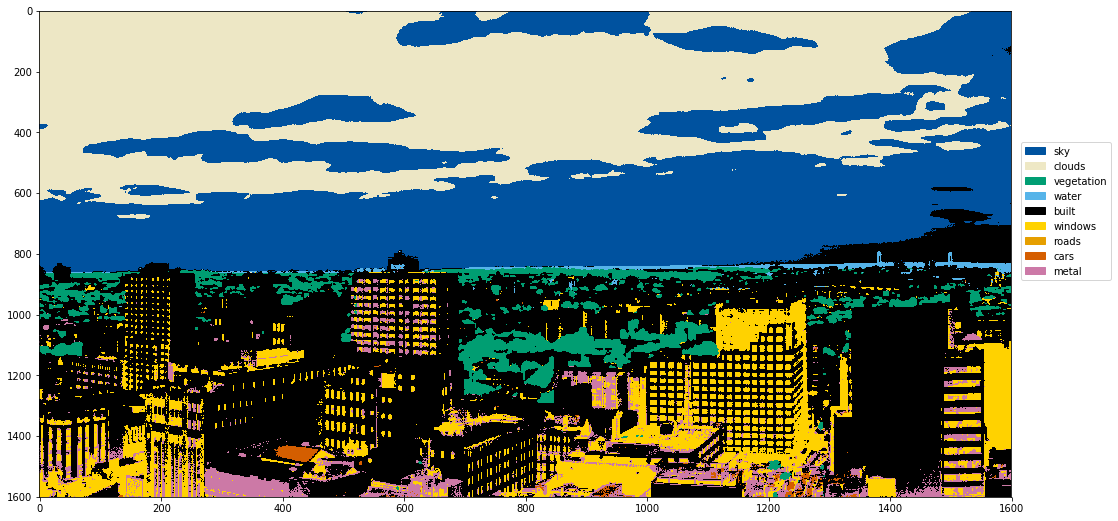

In [69]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

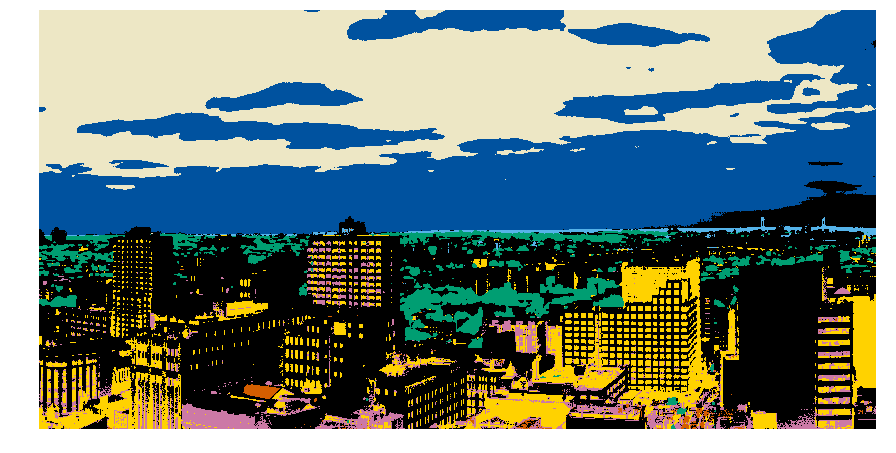

In [70]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_spatial_train_108_filter_size_10_predict_map.png", bbox_inches='tight', dpi=300)

In [71]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/CNN_spatial_train_108_filter_size_10_predict_map.pickle", "wb"))

### Evaluation Metrics (veg_00108) (filter size = 10)

In [72]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [73]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [74]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [75]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 118   0   2   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 196   8   0   0   0]
 [  0   0   0   0   8  85   0   0   7]
 [  0   0   0   0   1   0   0   0   5]
 [  0   0   0   0   4   1   0  12   3]
 [  0   0   0   0   6   5   0   0   9]]

Accuracy Score
0.921875

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      0.98      0.99       120
      water       1.00      1.00      1.00        10
      built       0.90      0.96      0.93       204
    windows       0.86      0.85      0.85       100
      roads       0.00      0.00      0.00         6
       cars       1.00      0.60      0.75        20
      metal       0.38      0.45      0.41        20

avg / total       0.92      0.92      0.92       64

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
f = open("./metrics/CNN_spatial_train_108_filter_size_10_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3    4    5  6   7   8
sky         300    0    0   0    0    0  0   0   0
clouds        1  499    0   0    0    0  0   0   0
vegetation    0    0  593   1    6    0  0   0   0
water         0    0    0  49    1    0  0   0   0
built         0    0    0   1  992   22  0   1   4
windows       0    0    0   0   23  455  0   4  18
roads         0    0    0   0    7    0  0   0  23
cars          4    0    0   0   25    9  0  46  16
metal         0    0    0   0   34   13  0   1  52


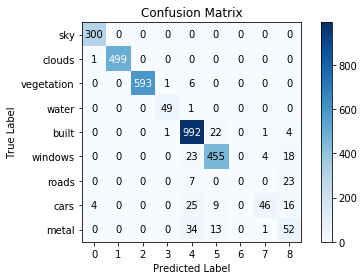

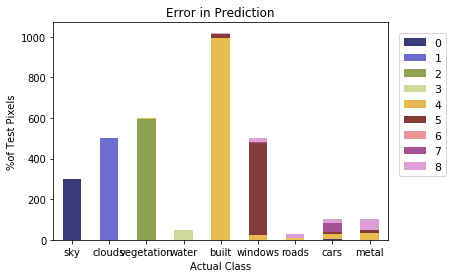

In [78]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

___
## Train CNN
### Filter size = 20
#### number fo filters = 16, 32

In [79]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(20), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(20), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Epoch 1/100
5/5 [==============================] - 1s 212ms/step - loss: 1.8102 - accuracy: 0.3949 - val_loss: 1.3186 - val_accuracy: 0.6719
Epoch 2/100
5/5 [==============================] - 1s 114ms/step - loss: 1.1317 - accuracy: 0.6625 - val_loss: 0.8767 - val_accuracy: 0.7516
Epoch 3/100
5/5 [==============================] - 1s 119ms/step - loss: 0.8319 - accuracy: 0.7480 - val_loss: 0.7313 - val_accuracy: 0.7234
Epoch 4/100
5/5 [==============================] - 1s 124ms/step - loss: 0.6987 - accuracy: 0.7984 - val_loss: 0.6270 - val_accuracy: 0.7875
Epoch 5/100
5/5 [==============================] - 1s 161ms/step - loss: 0.6162 - accuracy: 0.8137 - val_loss: 0.5258 - val_accuracy: 0.8641
Epoch 6/100
5/5 [==============================] - 1s 150ms/step - loss: 0.5475 - accuracy: 0.8414 - val_loss: 0.4876 - val_accuracy: 0.8391
Epoch 7/100
5/5 [==============================] - 1s 138ms/step - loss: 0.4859 - accuracy: 0.8582 - val_loss: 0.4384 - val_accuracy: 0.8750
Epoch 8/100
5

Epoch 59/100
5/5 [==============================] - 1s 112ms/step - loss: 0.1320 - accuracy: 0.9523 - val_loss: 0.1463 - val_accuracy: 0.9500
Epoch 60/100
5/5 [==============================] - 1s 101ms/step - loss: 0.1409 - accuracy: 0.9520 - val_loss: 0.1492 - val_accuracy: 0.9469
Epoch 61/100
5/5 [==============================] - 1s 105ms/step - loss: 0.1216 - accuracy: 0.9578 - val_loss: 0.1430 - val_accuracy: 0.9453
Epoch 62/100
5/5 [==============================] - 1s 115ms/step - loss: 0.1117 - accuracy: 0.9641 - val_loss: 0.1459 - val_accuracy: 0.9531
Epoch 63/100
5/5 [==============================] - 1s 141ms/step - loss: 0.1142 - accuracy: 0.9605 - val_loss: 0.1459 - val_accuracy: 0.9484
Epoch 64/100
5/5 [==============================] - 1s 132ms/step - loss: 0.1115 - accuracy: 0.9625 - val_loss: 0.1396 - val_accuracy: 0.9516
Epoch 65/100
5/5 [==============================] - 1s 127ms/step - loss: 0.1119 - accuracy: 0.9648 - val_loss: 0.1485 - val_accuracy: 0.9500
Epoch 

<function matplotlib.pyplot.show(*args, **kw)>

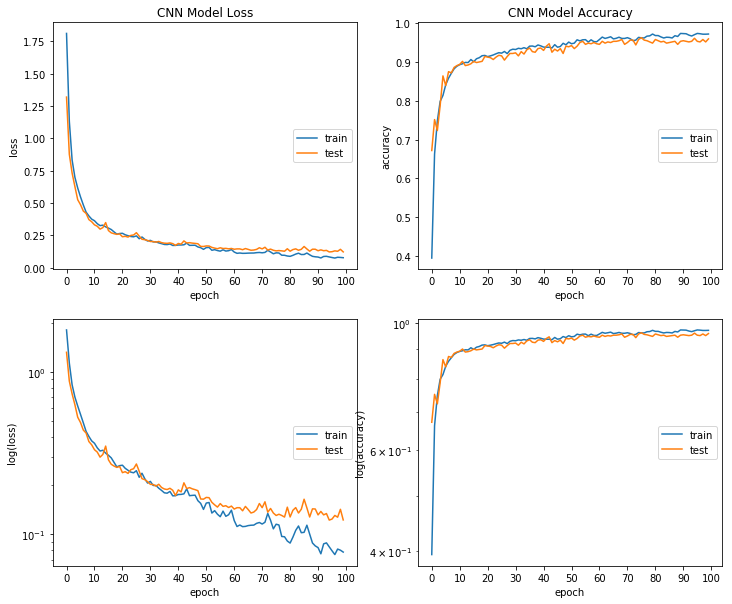

In [80]:
# summarize history of loss
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_change_params_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [81]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(20), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(20), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

!rm -rf ./logs/
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=50, batch_size=512, callbacks=[tensorboard_callback])

Epoch 1/50
2/5 [===========>..................] - ETA: 0s - loss: 2.0656 - accuracy: 0.2871

W0425 16:04:42.198755 140652027393536 callbacks.py:316] Callbacks method `on_train_batch_end` is slow compared to the batch time. Check your callbacks.


5/5 [==============================] - 1s 214ms/step - loss: 1.8673 - accuracy: 0.3855 - val_loss: 1.3829 - val_accuracy: 0.6797
Epoch 2/50
5/5 [==============================] - 1s 141ms/step - loss: 1.1939 - accuracy: 0.6281 - val_loss: 0.9590 - val_accuracy: 0.7109
Epoch 3/50
5/5 [==============================] - 1s 140ms/step - loss: 0.8664 - accuracy: 0.7539 - val_loss: 0.7479 - val_accuracy: 0.7516
Epoch 4/50
5/5 [==============================] - 1s 128ms/step - loss: 0.6896 - accuracy: 0.7973 - val_loss: 0.6137 - val_accuracy: 0.8687
Epoch 5/50
5/5 [==============================] - 1s 109ms/step - loss: 0.5739 - accuracy: 0.8527 - val_loss: 0.5145 - val_accuracy: 0.8516
Epoch 6/50
5/5 [==============================] - 1s 105ms/step - loss: 0.4928 - accuracy: 0.8625 - val_loss: 0.4414 - val_accuracy: 0.8719
Epoch 7/50
5/5 [==============================] - 1s 120ms/step - loss: 0.4382 - accuracy: 0.8703 - val_loss: 0.4039 - val_accuracy: 0.8797
Epoch 8/50
5/5 [===============

In [82]:
# model accuracy on training and testing sets

train_loss_20, train_acc_20 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_20, test_acc_20 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_20, test_acc_20)

20/20 [==============================] - 0s 10ms/step - loss: 0.2050 - accuracy: 0.9406
0.959765613079071 0.940625011920929


In [83]:
print(cube_train_labels.shape)
print(cube_test_labels.shape)

(2560,)
(640,)


In [84]:
from keras_sequential_ascii import keras2ascii
keras2ascii(cnn)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    850    1
              Conv1D    \|/  -------------------       336     0.0%
                relu   #####    850   16
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    425   16
              Conv1D    \|/  -------------------     10272     0.3%
                relu   #####    425   32
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    212   32
             Dropout    | || -------------------         0     0.0%
                       #####    212   32
             Flatten   ||||| -------------------         0     0.0%
                       #####        6784
               Dense   XXXXX -------------------   3473920    99.6%
                relu   #####         512
               Dense   XXXXX -------------------      4617     0.1%
             softmax   #####           9


In [85]:
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 850, 16)           336       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 425, 16)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 425, 32)           10272     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 212, 32)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 212, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6784)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)              

### Predict pixel classification on veg_00108 (filter size = 20)

In [86]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:08:41


In [87]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

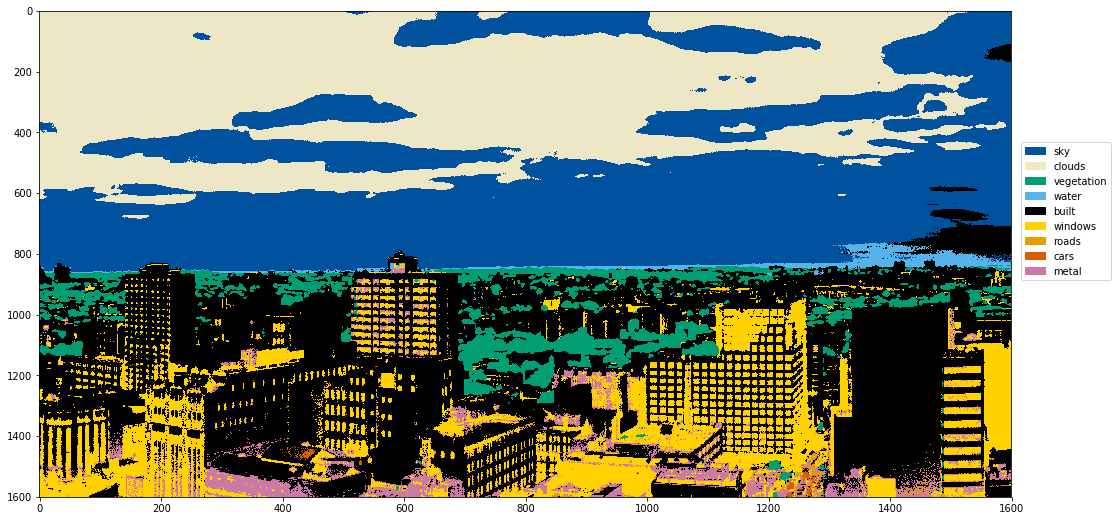

In [88]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

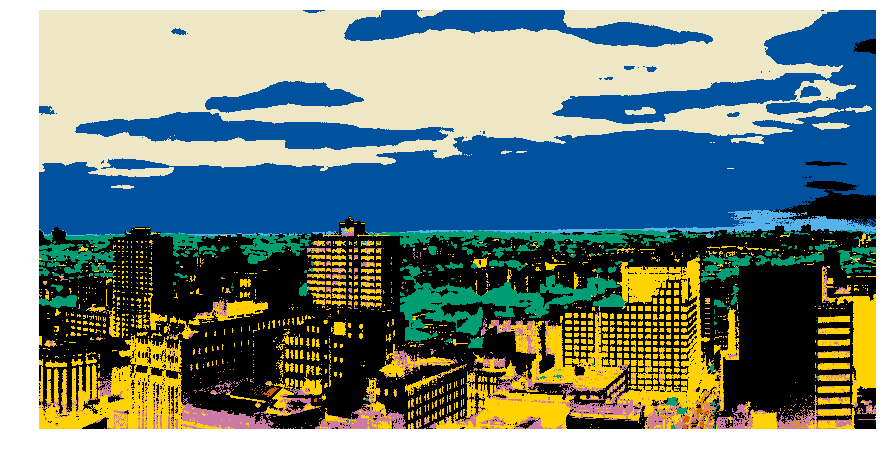

In [89]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_spatial_train_108_filter_size_20_predict_map.png", bbox_inches='tight', dpi=300)

In [90]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/CNN_spatial_train_108_filter_size_20_predict_map.pickle", "wb"))

### Evaluation Metrics (veg_00108) (filter size = 20)

In [91]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [92]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [93]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [94]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 119   0   1   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 195   9   0   0   0]
 [  0   0   0   0   7  92   0   0   1]
 [  0   0   0   0   0   0   6   0   0]
 [  0   0   0   0   3   2   1  10   4]
 [  0   0   0   0   3   7   0   0  10]]

Accuracy Score
0.940625

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      0.99      1.00       120
      water       1.00      1.00      1.00        10
      built       0.93      0.96      0.94       204
    windows       0.84      0.92      0.88       100
      roads       0.86      1.00      0.92         6
       cars       1.00      0.50      0.67        20
      metal       0.67      0.50      0.57        20

avg / total       0.94      0.94      0.94       64

In [95]:
f = open("./metrics/CNN_spatial_train_108_filter_size_20_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

In [96]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3    4    5   6   7   8
sky         300    0    0   0    0    0   0   0   0
clouds        1  499    0   0    0    0   0   0   0
vegetation    0    0  598   0    2    0   0   0   0
water         0    0    0  50    0    0   0   0   0
built         0    0    0   0  988   25   1   1   5
windows       0    0    0   0   16  483   0   0   1
roads         0    0    0   0    0    0  29   0   1
cars          0    0    0   0   18   15   2  49  16
metal         0    0    0   0   18   19   0   0  63


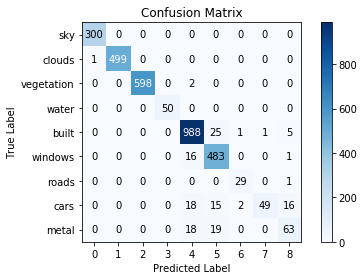

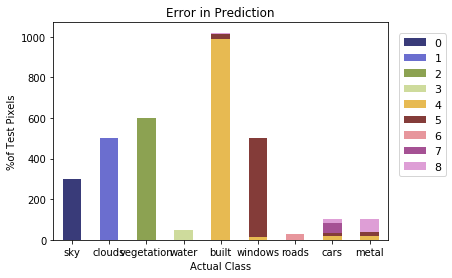

In [97]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

___
## Train CNN
### Filter size = 50
#### number fo filters = 16, 32

In [98]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Epoch 1/100
5/5 [==============================] - 1s 246ms/step - loss: 1.8040 - accuracy: 0.3734 - val_loss: 1.3883 - val_accuracy: 0.4969
Epoch 2/100
5/5 [==============================] - 1s 205ms/step - loss: 1.1582 - accuracy: 0.5844 - val_loss: 0.9309 - val_accuracy: 0.7312
Epoch 3/100
5/5 [==============================] - 1s 233ms/step - loss: 0.8643 - accuracy: 0.7285 - val_loss: 0.7554 - val_accuracy: 0.7953
Epoch 4/100
5/5 [==============================] - 1s 220ms/step - loss: 0.7078 - accuracy: 0.7707 - val_loss: 0.6341 - val_accuracy: 0.8203
Epoch 5/100
5/5 [==============================] - 1s 247ms/step - loss: 0.5883 - accuracy: 0.8332 - val_loss: 0.4955 - val_accuracy: 0.8672
Epoch 6/100
5/5 [==============================] - 1s 201ms/step - loss: 0.4749 - accuracy: 0.8648 - val_loss: 0.4167 - val_accuracy: 0.8719
Epoch 7/100
5/5 [==============================] - 1s 196ms/step - loss: 0.4348 - accuracy: 0.8707 - val_loss: 0.3908 - val_accuracy: 0.8797
Epoch 8/100
5

Epoch 59/100
5/5 [==============================] - 1s 172ms/step - loss: 0.1378 - accuracy: 0.9598 - val_loss: 0.1600 - val_accuracy: 0.9531
Epoch 60/100
5/5 [==============================] - 1s 217ms/step - loss: 0.1382 - accuracy: 0.9535 - val_loss: 0.1596 - val_accuracy: 0.9500
Epoch 61/100
5/5 [==============================] - 1s 187ms/step - loss: 0.1344 - accuracy: 0.9547 - val_loss: 0.1592 - val_accuracy: 0.9422
Epoch 62/100
5/5 [==============================] - 1s 215ms/step - loss: 0.1247 - accuracy: 0.9563 - val_loss: 0.1776 - val_accuracy: 0.9359
Epoch 63/100
5/5 [==============================] - 1s 181ms/step - loss: 0.1170 - accuracy: 0.9594 - val_loss: 0.1494 - val_accuracy: 0.9531
Epoch 64/100
5/5 [==============================] - 1s 171ms/step - loss: 0.1209 - accuracy: 0.9590 - val_loss: 0.1448 - val_accuracy: 0.9547
Epoch 65/100
5/5 [==============================] - 1s 208ms/step - loss: 0.1270 - accuracy: 0.9582 - val_loss: 0.1623 - val_accuracy: 0.9578
Epoch 

<function matplotlib.pyplot.show(*args, **kw)>

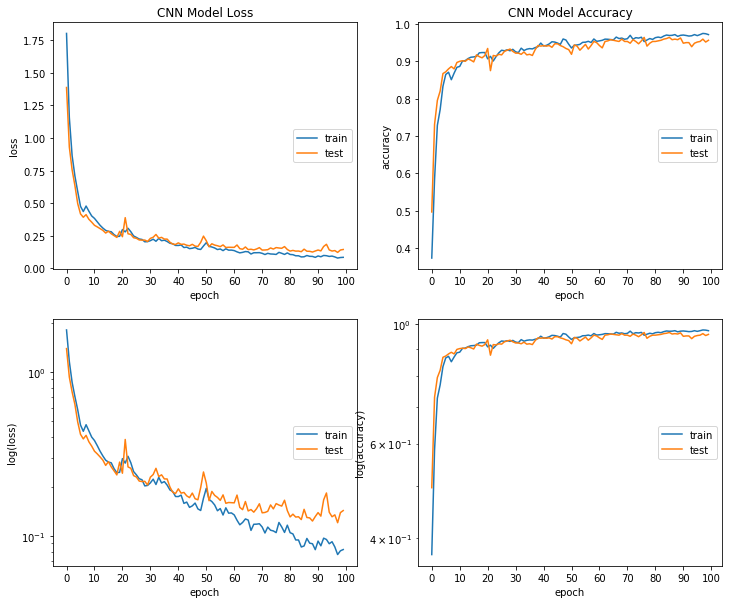

In [99]:
# summarize history of loss
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_change_params_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [100]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(50), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

!rm -rf ./logs/
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=40, batch_size=512, callbacks=[tensorboard_callback])

Epoch 1/40
2/5 [===========>..................] - ETA: 0s - loss: 2.2509 - accuracy: 0.2822

W0425 16:19:01.187680 140652027393536 callbacks.py:316] Callbacks method `on_train_batch_end` is slow compared to the batch time. Check your callbacks.


5/5 [==============================] - 1s 284ms/step - loss: 2.0042 - accuracy: 0.3430 - val_loss: 1.6324 - val_accuracy: 0.5109
Epoch 2/40
5/5 [==============================] - 1s 184ms/step - loss: 1.3175 - accuracy: 0.5691 - val_loss: 0.9447 - val_accuracy: 0.8062
Epoch 3/40
5/5 [==============================] - 1s 181ms/step - loss: 0.8566 - accuracy: 0.7348 - val_loss: 0.7173 - val_accuracy: 0.8234
Epoch 4/40
5/5 [==============================] - 1s 187ms/step - loss: 0.6827 - accuracy: 0.8047 - val_loss: 0.5772 - val_accuracy: 0.8219
Epoch 5/40
5/5 [==============================] - 1s 211ms/step - loss: 0.5621 - accuracy: 0.8391 - val_loss: 0.5114 - val_accuracy: 0.8313
Epoch 6/40
5/5 [==============================] - 1s 201ms/step - loss: 0.4902 - accuracy: 0.8434 - val_loss: 0.4564 - val_accuracy: 0.8703
Epoch 7/40
5/5 [==============================] - 1s 210ms/step - loss: 0.4393 - accuracy: 0.8648 - val_loss: 0.4168 - val_accuracy: 0.8797
Epoch 8/40
5/5 [===============

In [101]:
# model accuracy on training and testing sets

train_loss_50, train_acc_50 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_50, test_acc_50 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_50, test_acc_50)

20/20 [==============================] - 0s 7ms/step - loss: 0.1809 - accuracy: 0.9422
0.9476562738418579 0.942187488079071


In [102]:
print(cube_train_labels.shape)
print(cube_test_labels.shape)

(2560,)
(640,)


In [103]:
from keras_sequential_ascii import keras2ascii
keras2ascii(cnn)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    850    1
              Conv1D    \|/  -------------------       816     0.0%
                relu   #####    850   16
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    425   16
              Conv1D    \|/  -------------------     25632     0.7%
                relu   #####    425   32
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    212   32
             Dropout    | || -------------------         0     0.0%
                       #####    212   32
             Flatten   ||||| -------------------         0     0.0%
                       #####        6784
               Dense   XXXXX -------------------   3473920    99.1%
                relu   #####         512
               Dense   XXXXX -------------------      4617     0.1%
             softmax   #####           9


In [104]:
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 850, 16)           816       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 425, 16)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 425, 32)           25632     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 212, 32)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 212, 32)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6784)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)              

### Predict pixel classification on veg_00108 (filter size = 50)

In [105]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:09:49


In [106]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

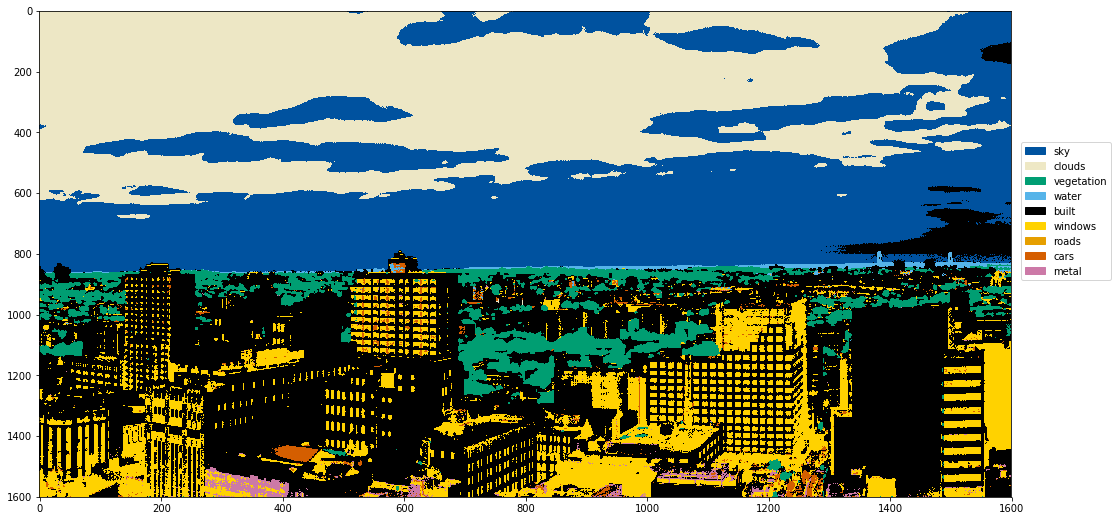

In [107]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

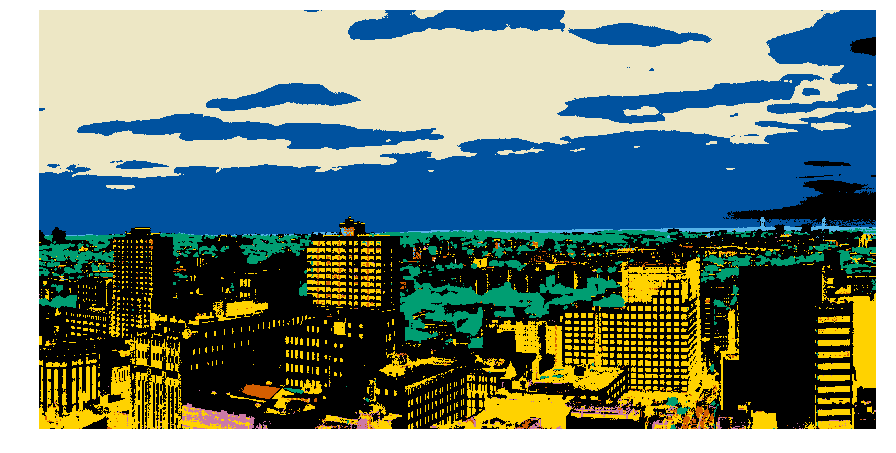

In [108]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_spatial_train_108_filter_size_50_predict_map.png", bbox_inches='tight', dpi=300)

In [109]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/CNN_spatial_train_108_filter_size_50_predict_map.pickle", "wb"))

### Evaluation Metrics (veg_00108) (filter size = 50)

In [110]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [111]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [112]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [113]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 119   0   1   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 196   8   0   0   0]
 [  0   0   0   0   6  94   0   0   0]
 [  0   0   0   0   2   1   3   0   0]
 [  0   0   0   0   3   1   0  16   0]
 [  0   0   0   0   9   6   0   0   5]]

Accuracy Score
0.9421875

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      0.99      1.00       120
      water       1.00      1.00      1.00        10
      built       0.90      0.96      0.93       204
    windows       0.85      0.94      0.90       100
      roads       1.00      0.50      0.67         6
       cars       1.00      0.80      0.89        20
      metal       1.00      0.25      0.40        20

avg / total       0.95      0.94      0.94       6

In [114]:
f = open("./metrics/CNN_spatial_train_108_filter_size_50_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

In [115]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3    4    5   6   7   8
sky         299    1    0   0    0    0   0   0   0
clouds        1  499    0   0    0    0   0   0   0
vegetation    0    0  598   0    2    0   0   0   0
water         0    0    0  50    0    0   0   0   0
built         0    0    2   0  993   23   0   1   1
windows       0    0    0   0   18  478   0   4   0
roads         0    0    0   0   13    1  14   1   1
cars          0    0    0   0   19    9   0  72   0
metal         0    0    0   0   49   23   0   2  26


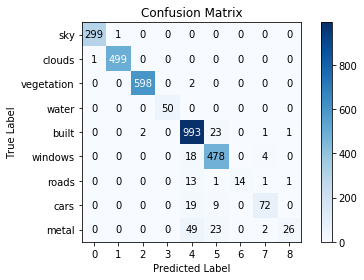

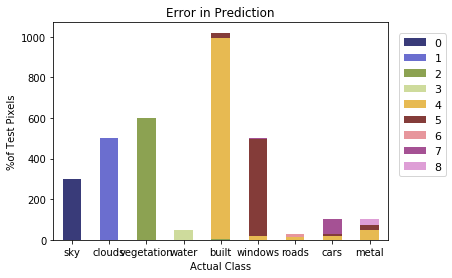

In [116]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

___
## Train CNN
### Filter size = 100
#### number fo filters = 16, 32

In [117]:
import tensorflow as tf
from tensorflow import keras

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(100), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(100), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=100, batch_size=512)

Epoch 1/100
5/5 [==============================] - 2s 417ms/step - loss: 2.2750 - accuracy: 0.3316 - val_loss: 1.8807 - val_accuracy: 0.4500
Epoch 2/100
5/5 [==============================] - 2s 369ms/step - loss: 1.5689 - accuracy: 0.5168 - val_loss: 1.0683 - val_accuracy: 0.6500
Epoch 3/100
5/5 [==============================] - 2s 314ms/step - loss: 0.9913 - accuracy: 0.6812 - val_loss: 0.8393 - val_accuracy: 0.7391
Epoch 4/100
5/5 [==============================] - 2s 391ms/step - loss: 0.8035 - accuracy: 0.7293 - val_loss: 0.7395 - val_accuracy: 0.7703
Epoch 5/100
5/5 [==============================] - 2s 362ms/step - loss: 0.7265 - accuracy: 0.7609 - val_loss: 0.6414 - val_accuracy: 0.8109
Epoch 6/100
5/5 [==============================] - 2s 363ms/step - loss: 0.6511 - accuracy: 0.7926 - val_loss: 0.5989 - val_accuracy: 0.7937
Epoch 7/100
5/5 [==============================] - 2s 360ms/step - loss: 0.5843 - accuracy: 0.8074 - val_loss: 0.5368 - val_accuracy: 0.8141
Epoch 8/100
5

Epoch 59/100
5/5 [==============================] - 2s 367ms/step - loss: 0.1823 - accuracy: 0.9363 - val_loss: 0.1997 - val_accuracy: 0.9359
Epoch 60/100
5/5 [==============================] - 2s 312ms/step - loss: 0.1802 - accuracy: 0.9359 - val_loss: 0.1840 - val_accuracy: 0.9375
Epoch 61/100
5/5 [==============================] - 2s 339ms/step - loss: 0.1728 - accuracy: 0.9410 - val_loss: 0.1739 - val_accuracy: 0.9422
Epoch 62/100
5/5 [==============================] - 2s 381ms/step - loss: 0.1649 - accuracy: 0.9449 - val_loss: 0.1790 - val_accuracy: 0.9516
Epoch 63/100
5/5 [==============================] - 1s 291ms/step - loss: 0.1772 - accuracy: 0.9418 - val_loss: 0.1824 - val_accuracy: 0.9359
Epoch 64/100
5/5 [==============================] - 2s 365ms/step - loss: 0.1710 - accuracy: 0.9438 - val_loss: 0.1892 - val_accuracy: 0.9422
Epoch 65/100
5/5 [==============================] - 2s 367ms/step - loss: 0.1671 - accuracy: 0.9461 - val_loss: 0.1821 - val_accuracy: 0.9391
Epoch 

<function matplotlib.pyplot.show(*args, **kw)>

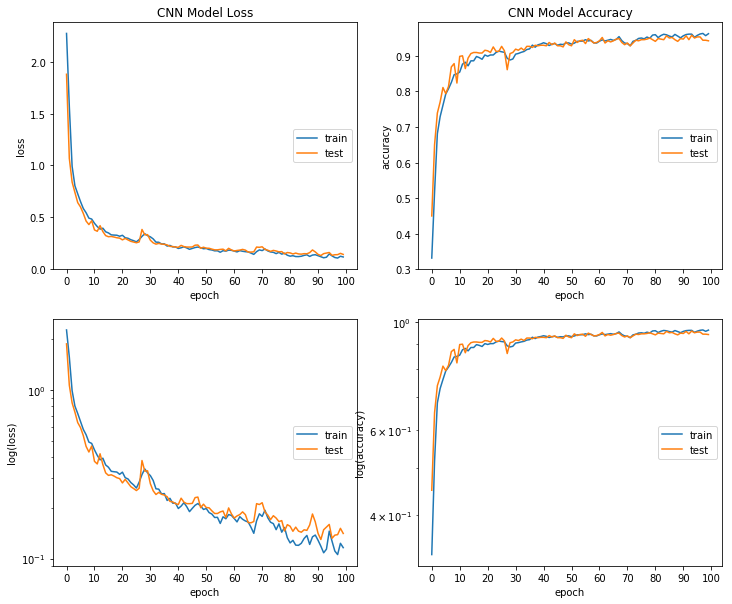

In [118]:
# summarize history of loss
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodel.history['loss'])
ax1.plot(CNNmodel.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodel.history['accuracy'])
ax2.plot(CNNmodel.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodel.history['loss'])
ax3.plot(CNNmodel.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodel.history['accuracy'])
ax4.plot(CNNmodel.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
#f.savefig("./plots/CNN_change_params_spatial_train_108_5_CNN_loss_accuracy_vs_epoch.png")

In [119]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

cnn = keras.Sequential([keras.layers.Conv1D(16, kernel_size=(100), padding="same", 
                                            activation="relu", input_shape=(cube_specxy.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(32, kernel_size=(100), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Dropout(0.5),
                        keras.layers.Flatten(),
                        keras.layers.Dense(512, activation="relu"),
                        keras.layers.Dense(9, activation="softmax")])

cnn.compile(optimizer="adam", loss=["sparse_categorical_crossentropy"], metrics=['accuracy'])

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

!rm -rf ./logs/
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

CNNmodel = cnn.fit(cube_train2, cube_train_labels, validation_data=(cube_test2, cube_test_labels), 
                   epochs=40, batch_size=512, callbacks=[tensorboard_callback])

Epoch 1/40
5/5 [==============================] - 2s 375ms/step - loss: 2.3152 - accuracy: 0.3832 - val_loss: 1.6900 - val_accuracy: 0.5688
Epoch 2/40
5/5 [==============================] - 2s 346ms/step - loss: 1.3518 - accuracy: 0.5750 - val_loss: 1.0214 - val_accuracy: 0.7094
Epoch 3/40
5/5 [==============================] - 2s 307ms/step - loss: 0.9439 - accuracy: 0.6953 - val_loss: 0.8263 - val_accuracy: 0.7500
Epoch 4/40
5/5 [==============================] - 2s 317ms/step - loss: 0.7750 - accuracy: 0.7445 - val_loss: 0.7018 - val_accuracy: 0.7859
Epoch 5/40
5/5 [==============================] - 2s 352ms/step - loss: 0.6981 - accuracy: 0.7684 - val_loss: 0.6632 - val_accuracy: 0.7922
Epoch 6/40
5/5 [==============================] - 2s 381ms/step - loss: 0.6420 - accuracy: 0.7848 - val_loss: 0.5779 - val_accuracy: 0.8188
Epoch 7/40
5/5 [==============================] - 2s 321ms/step - loss: 0.5990 - accuracy: 0.8059 - val_loss: 0.5375 - val_accuracy: 0.7984
Epoch 8/40
5/5 [====

In [120]:
# model accuracy on training and testing sets

train_loss_100, train_acc_100 = cnn.evaluate(cube_train2, cube_train_labels)
test_loss_100, test_acc_100 = cnn.evaluate(cube_test2, cube_test_labels)

print(train_acc_100, test_acc_100)

20/20 [==============================] - 0s 10ms/step - loss: 0.2094 - accuracy: 0.9250
0.9371093511581421 0.925000011920929


In [121]:
print(cube_train_labels.shape)
print(cube_test_labels.shape)

(2560,)
(640,)


In [122]:
from keras_sequential_ascii import keras2ascii
keras2ascii(cnn)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    850    1
              Conv1D    \|/  -------------------      1616     0.0%
                relu   #####    850   16
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    425   16
              Conv1D    \|/  -------------------     51232     1.5%
                relu   #####    425   32
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    212   32
             Dropout    | || -------------------         0     0.0%
                       #####    212   32
             Flatten   ||||| -------------------         0     0.0%
                       #####        6784
               Dense   XXXXX -------------------   3473920    98.4%
                relu   #####         512
               Dense   XXXXX -------------------      4617     0.1%
             softmax   #####           9


In [123]:
cnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 850, 16)           1616      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 425, 16)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 425, 32)           51232     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 212, 32)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 212, 32)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 6784)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)             

### Predict pixel classification on veg_00108 (filter size = 100)

In [124]:
# classify entire binned cube
import time
start_time = time.time()

cube_specxy_2d_1 = cube_specxy_2d.reshape(cube_specxy_2d.shape[0], cube_specxy_2d.shape[1], 1)
predictCube = cnn.predict_classes(cube_specxy_2d_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:10:39


In [125]:
predictCube_reshape = predictCube.reshape(cube_specxy.shape[0], cube_specxy.shape[1])

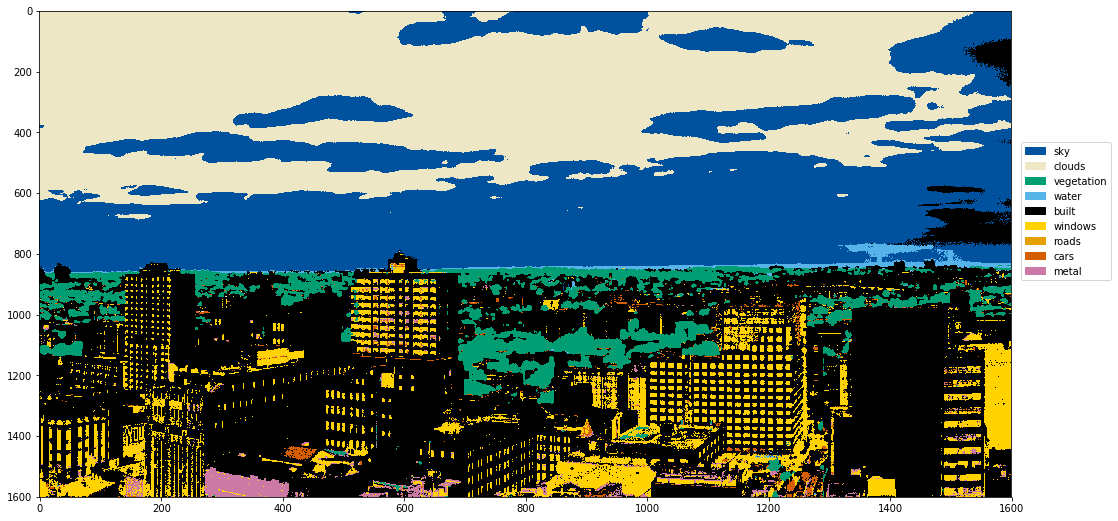

In [126]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_108_6_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

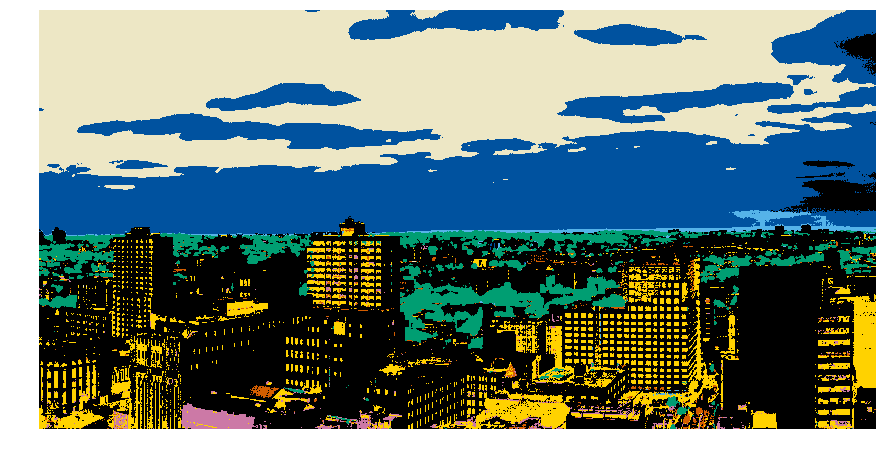

In [127]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_spatial_train_108_filter_size_100_predict_map.png", bbox_inches='tight', dpi=300)

In [128]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/CNN_spatial_train_108_filter_size_100_predict_map.pickle", "wb"))

### Evaluation Metrics (veg_00108) (filter size = 100)

In [129]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [130]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [131]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [132]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 119   0   1   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 200   4   0   0   0]
 [  0   0   0   0  10  88   0   0   2]
 [  0   0   0   0   6   0   0   0   0]
 [  0   0   0   0   6   1   0  12   1]
 [  0   0   0   0  15   2   0   0   3]]

Accuracy Score
0.925

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      0.99      1.00       120
      water       1.00      1.00      1.00        10
      built       0.84      0.98      0.90       204
    windows       0.93      0.88      0.90       100
      roads       0.00      0.00      0.00         6
       cars       1.00      0.60      0.75        20
      metal       0.50      0.15      0.23        20

avg / total       0.91      0.93      0.91       640



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [133]:
f = open("./metrics/CNN_spatial_train_108_filter_size_100_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [134]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0    1    2   3     4    5  6   7   8
sky         299    1    0   0     0    0  0   0   0
clouds        0  500    0   0     0    0  0   0   0
vegetation    0    0  598   0     2    0  0   0   0
water         0    0    0  50     0    0  0   0   0
built         0    0    2   0  1009    9  0   0   0
windows       0    0    0   0    42  454  0   1   3
roads         0    0    0   0    30    0  0   0   0
cars          0    0    0   0    30    8  0  60   2
metal         0    0    1   0    71    7  0   0  21


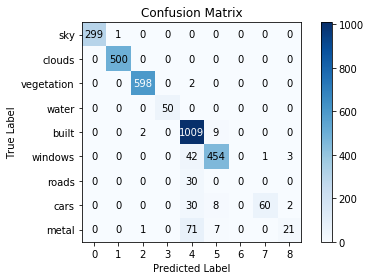

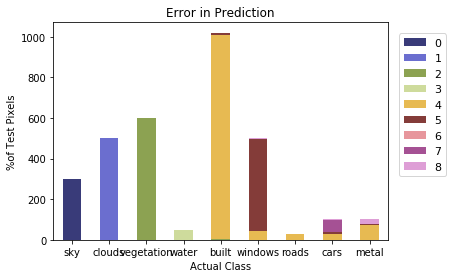

In [135]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)


---

## Plot results

In [136]:
train_acc = [train_acc_100, 0.9574219, train_acc_20, train_acc_10, train_acc_5, train_acc_2]
test_acc =[test_acc_100, 0.9546875, test_acc_20, test_acc_10, test_acc_5, train_acc_2]

print(train_acc)
print(test_acc)

[0.9371093511581421, 0.9476562738418579, 0.959765613079071, 0.9359375238418579, 0.9242187738418579, 0.9058593511581421]
[0.925000011920929, 0.942187488079071, 0.940625011920929, 0.921875, 0.9140625, 0.9058593511581421]


In [1]:
import numpy as np

train_acc = [0.9371093511581421, 0.9574219, 0.959765613079071, 0.9359375238418579, 0.9242187738418579, 0.9058593511581421]
test_acc = [0.925000011920929, 0.9546875, 0.940625011920929, 0.921875, 0.9140625, 0.9058593511581421]

In [2]:
n_groups = 6

avg_prec = np.zeros(n_groups)
avg_recall = np.zeros(n_groups)
avg_f1 = np.zeros(n_groups)
sky_prec = np.zeros(n_groups)
sky_recall = np.zeros(n_groups)
sky_f1 = np.zeros(n_groups)
clouds_prec = np.zeros(n_groups)
clouds_recall = np.zeros(n_groups)
clouds_f1 = np.zeros(n_groups)
veg_prec = np.zeros(n_groups)
veg_recall = np.zeros(n_groups)
veg_f1 = np.zeros(n_groups)
wtr_prec = np.zeros(n_groups)
wtr_recall = np.zeros(n_groups)
wtr_f1 = np.zeros(n_groups)
blt_prec = np.zeros(n_groups)
blt_recall = np.zeros(n_groups)
blt_f1 = np.zeros(n_groups)
windows_prec = np.zeros(n_groups)
windows_recall = np.zeros(n_groups)
windows_f1 = np.zeros(n_groups)
rds_prec = np.zeros(n_groups)
rds_recall = np.zeros(n_groups)
rds_f1 = np.zeros(n_groups)
cars_prec = np.zeros(n_groups)
cars_recall = np.zeros(n_groups)
cars_f1 = np.zeros(n_groups)
mtl_prec = np.zeros(n_groups)
mtl_recall = np.zeros(n_groups)
mtl_f1 = np.zeros(n_groups)

In [3]:
def read_prec_recall(file, line):
    Nums = []
    for num in file[line].split():
        try:
            Nums.append(float(num))
        except ValueError:
            pass
    prec = Nums[0]
    recall = Nums[1]
    f1 = Nums[2]
    
    return prec, recall, f1

In [4]:
filter_size = [100, 50, 20, 10, 5, 2]

i=0
for size in filter_size:
    filename = "./metrics/CNN_spatial_train_108_filter_size_" + str(size) + "_metrics.txt"
    f = open(filename, "r")
    f1 = f.readlines()

    avg_prec[i], avg_recall[i], avg_f1[i] = read_prec_recall(f1, 27)
    sky_prec[i], sky_recall[i], sky_f1[i] = read_prec_recall(f1, 17)
    clouds_prec[i], clouds_recall[i], clouds_f1[i] = read_prec_recall(f1, 18)
    veg_prec[i], veg_recall[i], veg_f1[i] = read_prec_recall(f1, 19)
    wtr_prec[i], wtr_recall[i], wtr_f1[i] = read_prec_recall(f1, 20) 
    blt_prec[i], blt_recall[i], blt_f1[i] = read_prec_recall(f1, 21)
    windows_prec[i], windows_recall[i], windows_f1[i] = read_prec_recall(f1, 22)
    rds_prec[i], rds_recall[i], rds_f1[i] = read_prec_recall(f1, 23)
    cars_prec[i], cars_recall[i], cars_f1[i] = read_prec_recall(f1, 24)
    mtl_prec[i], mtl_recall[i], mtl_f1[i] = read_prec_recall(f1, 25)
    
    f.close()
    i += 1

In [6]:
filename = "./metrics/CNN_change_params_spatial_train_108_test_108_binned_848_metrics.txt"
f = open(filename, "r")
f1 = f.readlines()
i=1
avg_prec[i], avg_recall[i], avg_f1[i] = read_prec_recall(f1, 27)
sky_prec[i], sky_recall[i], sky_f1[i] = read_prec_recall(f1, 17)
clouds_prec[i], clouds_recall[i], clouds_f1[i] = read_prec_recall(f1, 18)
veg_prec[i], veg_recall[i], veg_f1[i] = read_prec_recall(f1, 19)
wtr_prec[i], wtr_recall[i], wtr_f1[i] = read_prec_recall(f1, 20) 
blt_prec[i], blt_recall[i], blt_f1[i] = read_prec_recall(f1, 21)
windows_prec[i], windows_recall[i], windows_f1[i] = read_prec_recall(f1, 22)
rds_prec[i], rds_recall[i], rds_f1[i] = read_prec_recall(f1, 23)
cars_prec[i], cars_recall[i], cars_f1[i] = read_prec_recall(f1, 24)
mtl_prec[i], mtl_recall[i], mtl_f1[i] = read_prec_recall(f1, 25)
    
f.close()

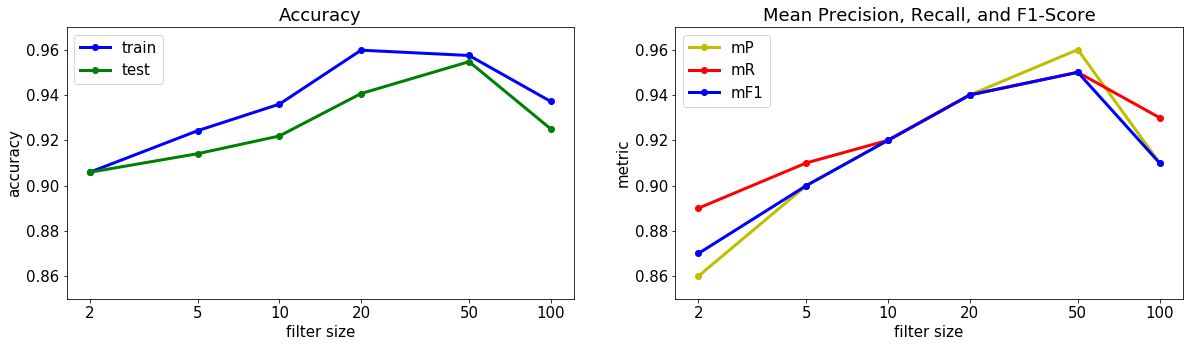

In [31]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
       'size' : 15}
matplotlib.rc('font', **font)

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(filter_size, train_acc, '-o', color='b', lw=3, label='train')
ax1.plot(filter_size, test_acc, '-o', color='g', lw=3, label='test')
ax1.set_title("Accuracy")
ax1.set_xlabel("filter size")
ax1.set_ylabel("accuracy")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)
ax1.set_xscale('log', basex=2)
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.set_xticks(filter_size)
ax1.set_ylim(0.85,0.97)

ax2.plot(filter_size, avg_prec, '-o', color='y', lw=3, label='mP')
ax2.plot(filter_size, avg_recall, '-o', color='r', lw=3, label='mR')
ax2.plot(filter_size, avg_f1, '-o', color='b', lw=3, label='mF1')
ax2.set_title("Mean Precision, Recall, and F1-Score")
ax2.set_xlabel("filter size")
ax2.set_ylabel("metric")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)
ax2.set_xscale('log', basex=2)
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.set_xticks(filter_size)
ax2.set_ylim(0.85,0.97)

plt.show()
fig.savefig("./plots/CNN_spatial_train_108_Overall_Binned_metrics.png", bbox_inches='tight')